In [38]:
import GPy
import optunity
import sobol
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [4]:
def f(x, y):
    return x**2-x + y**2 + y-np.cos(2*np.pi*x - np.pi) - np.cos(2*np.pi*y + np.pi) + 2.5

In [65]:
x = np.linspace(-6,6,2000)
y = np.linspace(-6,6,2000)
X,Y = np.meshgrid(x,y)

In [140]:
def plot(Z,contour=True):
    if not contour:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, GP_model.predict(coord)[0].reshape(X.shape))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('f(x,y)')
        ax.set_title('initial GP approximation')
        plt.show()
    else:
        plt.figure(figsize=(10,6))
        plt.contourf(X, Y, f(X,Y),50)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('f(x,y)')
        plt.colorbar()
        plt.show()

In [141]:
f_xy= f(X,Y)

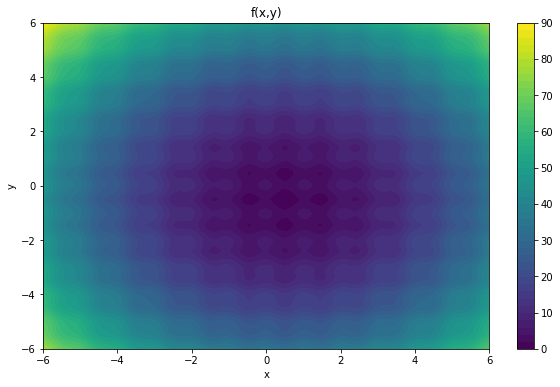

In [139]:
fig = plt.figure(figsize=(10,6))
plt.contourf(X, Y, f_xy,50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x,y)')
plt.colorbar()
plt.show()

In [159]:
#Expected Improvement:
def u(x,y,gp=GP_model):
    q=np.array([[x,y]])
    Ebest=min(gp.Y)
    mean,var=gp.predict(q)
    std=np.sqrt(var)
    g=(Ebest-mean)/std
    return std*(g*scipy.stats.norm.cdf(g)+scipy.stats.norm.pdf(g))

In [180]:
import sobol
number_of_samples = 30
parameterUpperLimits = np. array ([6 ,6])
parameterLowerLimits = np. array ([ -6 , -6])
Q=[]
for i in range ( number_of_samples ):
    x,y = sobol.i4_sobol(2 ,i)[0]*(parameterUpperLimits - parameterLowerLimits ) + parameterLowerLimits
    Q.append([x,y])
train=np.array(Q)
Q=train.copy()

In [167]:
#calculate the true values
E=f(*Q.T).reshape(-1,1)

In [168]:
GP_model=GPy.models.GPRegression(Q,E,kernel=GPy.kern.RBF(2) + GPy.kern.White(2))

In [163]:
coord=np.vstack((X,Y)).reshape(2,-1).T

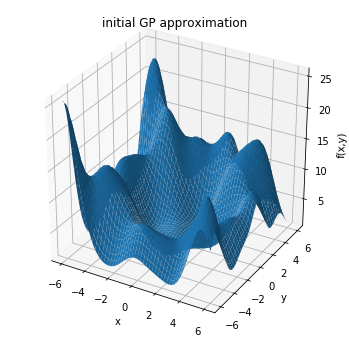

In [78]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, GP_model.predict(coord)[0].reshape(X.shape))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('initial GP approximation')
plt.show()

In [169]:
#optimization
for i in range(30):
    _, details, _ = optunity.maximize(u, num_evals=100, x=[-6, 6], y=[-6, 6])
    best_ind=np.where(details.call_log['values']==details.optimum)[0][0]
    x,y=details.call_log['args']['x'][best_ind],details.call_log['args']['y'][best_ind]
    Q=np.append(Q,[[x,y]],axis=0)
    E=f(*Q.T).reshape(-1,1)
    GP_model=GPy.models.GPRegression(Q,E,kernel=GPy.kern.RBF(2) + GPy.kern.White(2))
    #Print the true function values and the function values predicted by the GP as a function of iteration number
    #-Which values were asked for?

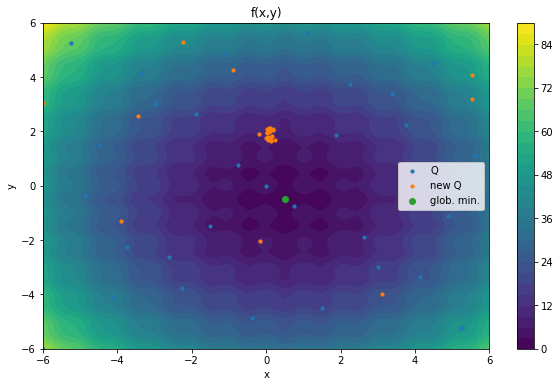

In [171]:
fig = plt.figure(figsize=(10,6))
plt.contourf(X, Y,f_xy,30)
plt.colorbar()
plt.scatter(*Q[:30].T,s=10,label='Q')
plt.scatter(*Q[30:].T,s=10,label='new Q')
plt.scatter(.5,-.5,label='glob. min.')
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x,y)')
plt.legend()
plt.show()

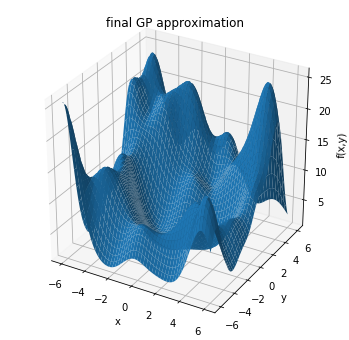

In [179]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, GP_model.predict(coord)[0].reshape(X.shape))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('final GP approximation')
plt.show()

In [182]:
#repeat experiment with two utility functions
def varGP(x,y,gp=GP_model):
    q=np.array([[x,y]])
    return gp.predict(q)[1]

In [184]:
#optimization
for i in range(30):
    _, details, _ = optunity.maximize(u if i%2==0 else varGP, num_evals=100, x=[-6, 6], y=[-6, 6])
    best_ind=np.where(details.call_log['values']==details.optimum)[0][0]
    x,y=details.call_log['args']['x'][best_ind],details.call_log['args']['y'][best_ind]
    Q=np.append(Q,[[x,y]],axis=0)
    E=f(*Q.T).reshape(-1,1)
    GP_model=GPy.models.GPRegression(Q,E,kernel=GPy.kern.RBF(2) + GPy.kern.White(2))

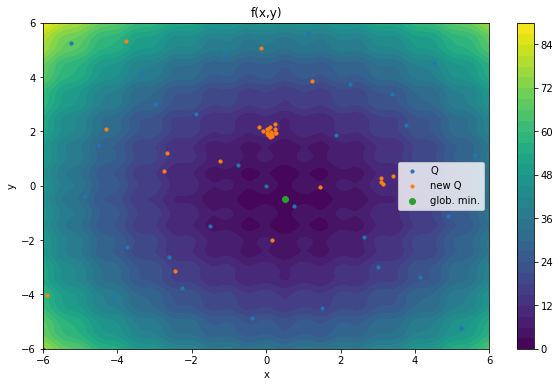

In [185]:
fig = plt.figure(figsize=(10,6))
plt.contourf(X, Y,f_xy,30)
plt.colorbar()
plt.scatter(*Q[:30].T,s=10,label='Q')
plt.scatter(*Q[30:].T,s=10,label='new Q')
plt.scatter(.5,-.5,label='glob. min.')
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x,y)')
plt.legend()
plt.show()

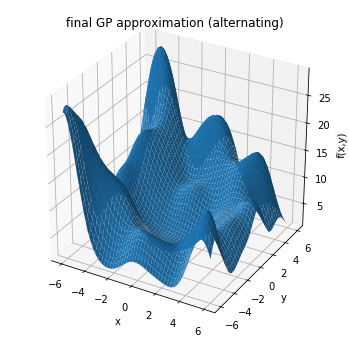

In [187]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, GP_model.predict(coord)[0].reshape(X.shape))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('final GP approximation (alternating)')
plt.show()

In [198]:
#As a baseline, also compute 60 values of f(x, y) for uniformly random points in [−6, 6]^2 
#and compare their minimum with the best value found by Bayesian optimization
q_uni=12*np.random.random((2,60))-6
min(f(q_uni[0],q_uni[1]))

1.5138900496600467